# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
import skfuzzy as fuzz
# import cmeans

c:\Users\tneto\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [15]:
# Load datasets
white_wine = pd.read_csv('winequality-white.csv', sep=';')
red_wine = pd.read_csv('winequality-red.csv', sep=';')

# Add a column to identify wine type
white_wine['wine_type'] = 0
red_wine['wine_type'] = 1

print('White wine shape', white_wine.shape)
print('Red wine shape', red_wine.shape)

White wine shape (4898, 13)
Red wine shape (1599, 13)


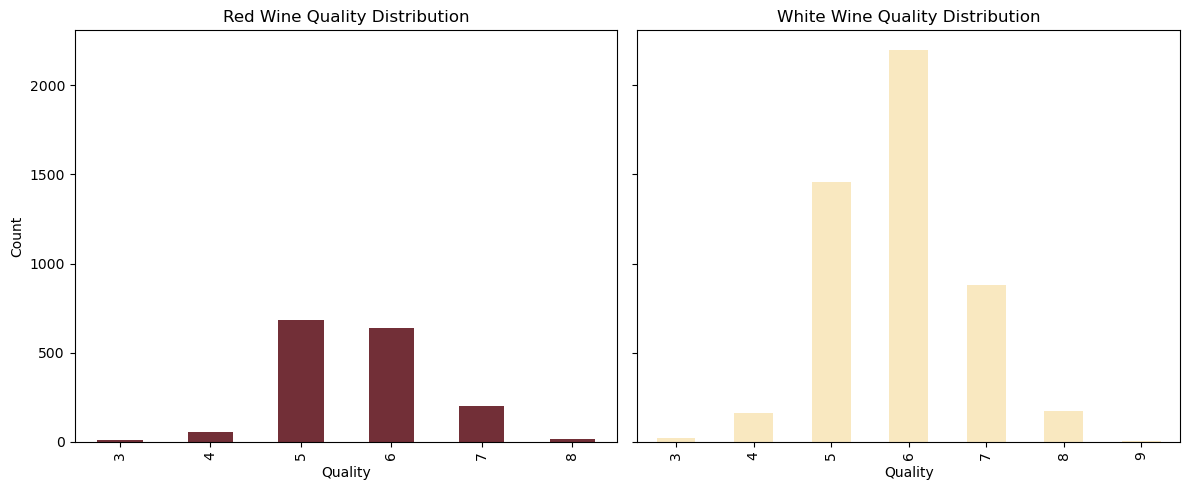

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # 1 row, 2 columns

white_wine['quality'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='#f9e8c0')
axes[1].set_title('White Wine Quality Distribution')
axes[1].set_xlabel('Quality')
axes[0].set_ylabel('Count')

red_wine['quality'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='#722F37')
axes[0].set_title('Red Wine Quality Distribution')
axes[0].set_xlabel('Quality')

plt.tight_layout()
plt.show()

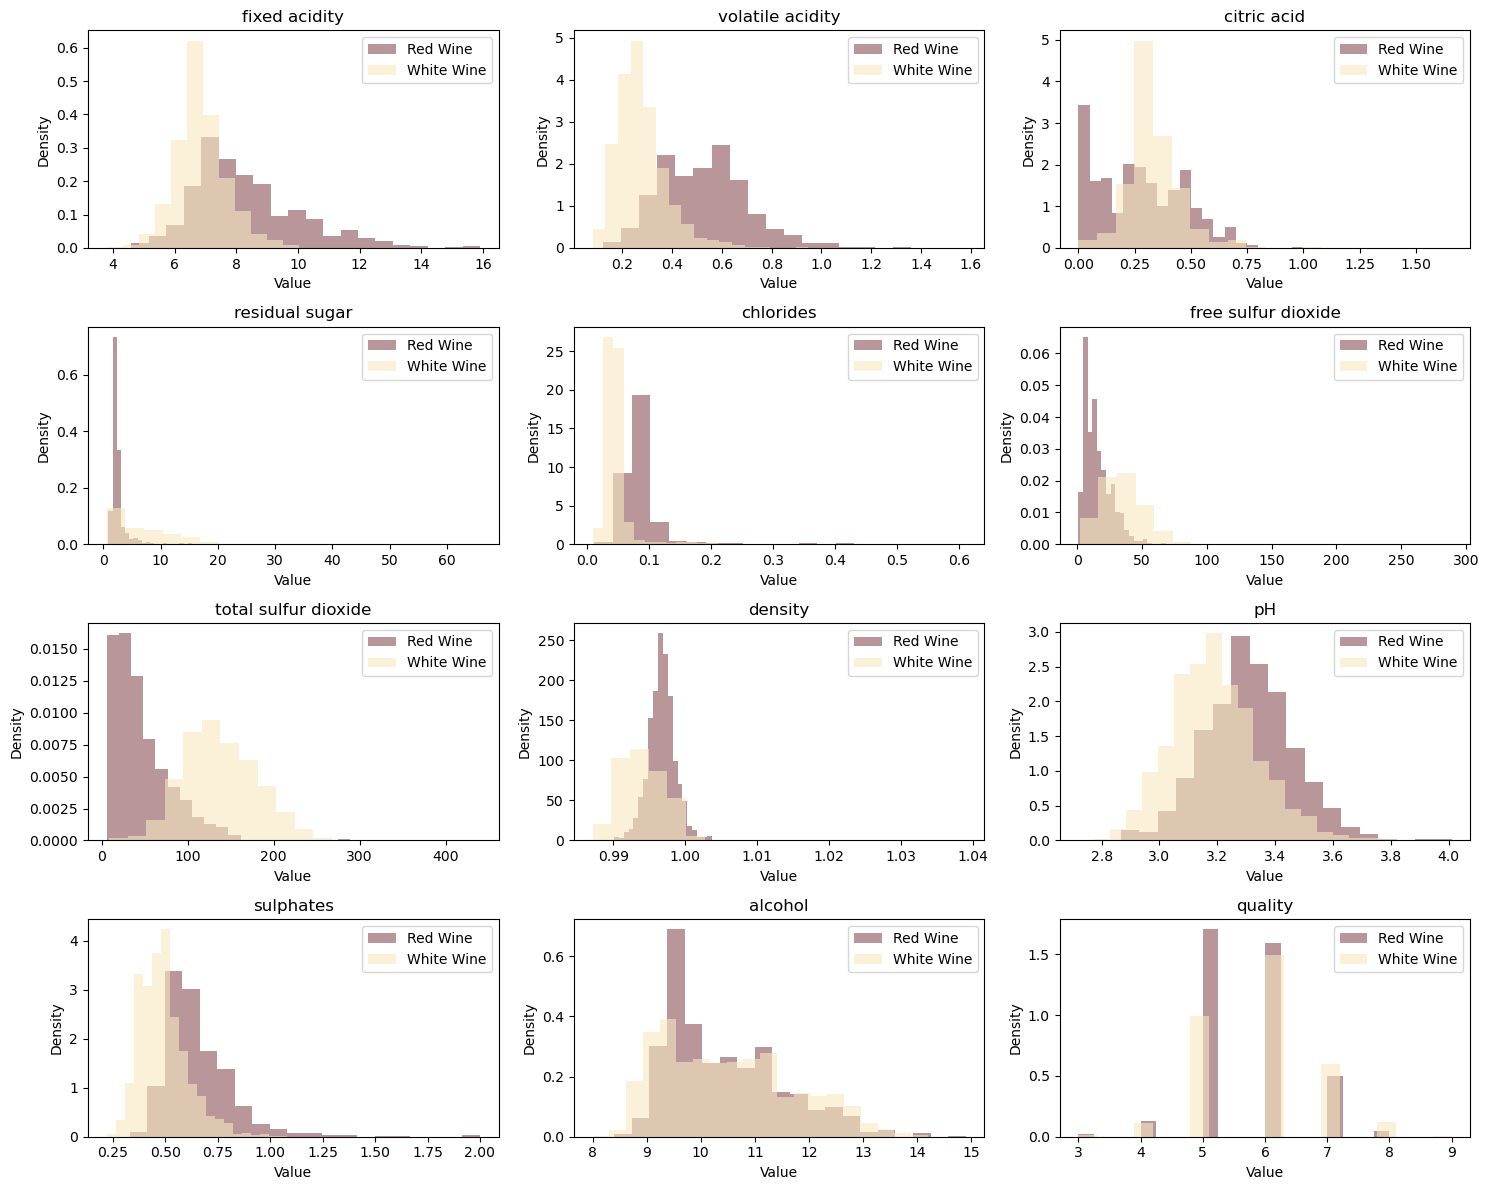

In [20]:
red_wine = pd.read_csv('winequality-red.csv', sep=';')
white_wine = pd.read_csv('winequality-white.csv', sep=';')

features = [col for col in red_wine.columns]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    # Plot red and white wine histograms on the same axes
    axes[i].hist(red_wine[feature], bins=20, color='#722F37', alpha=0.5, label='Red Wine', density=True)
    axes[i].hist(white_wine[feature], bins=20, color='#f9e8c0', alpha=0.6, label='White Wine', density=True)

    axes[i].set_title(feature, fontsize=12)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Density")
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Combine datasets
data = pd.concat([red_wine, white_wine])

white_wine.drop('wine_type', axis=1, inplace=True)
red_wine.drop('wine_type', axis=1, inplace=True)

data.head(-1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4892,6.5,0.23,0.38,1.3,0.032,29.0,112.0,0.99298,3.29,0.54,9.7,5,1
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,1
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1


We will be first using white wine since it is the dataset with more data from the 2 provided

# White Wine

In [21]:
print('Dataset shape:', white_wine.shape)
print('Dataset has', white_wine.shape[0],'data points and', white_wine.shape[1], 'features.')
print("Dataset number of array dimensions: ", white_wine.ndim)
print("Dataset number of elements: ", white_wine.size)

Dataset shape: (4898, 12)
Dataset has 4898 data points and 12 features.
Dataset number of array dimensions:  2
Dataset number of elements:  58776


In [22]:
print(white_wine.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
None


In [23]:
print(white_wine.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000         

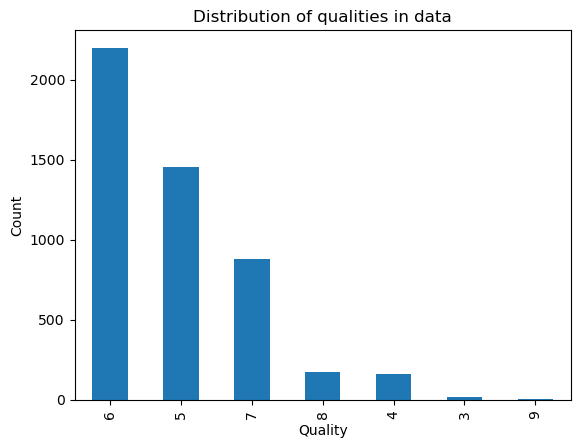

In [24]:
white_wine['quality'].value_counts().plot(kind='bar')

# Adding titles and labels
plt.title('Distribution of qualities in data')
plt.xlabel('Quality')
plt.ylabel('Count')

# Display the plot
plt.show()

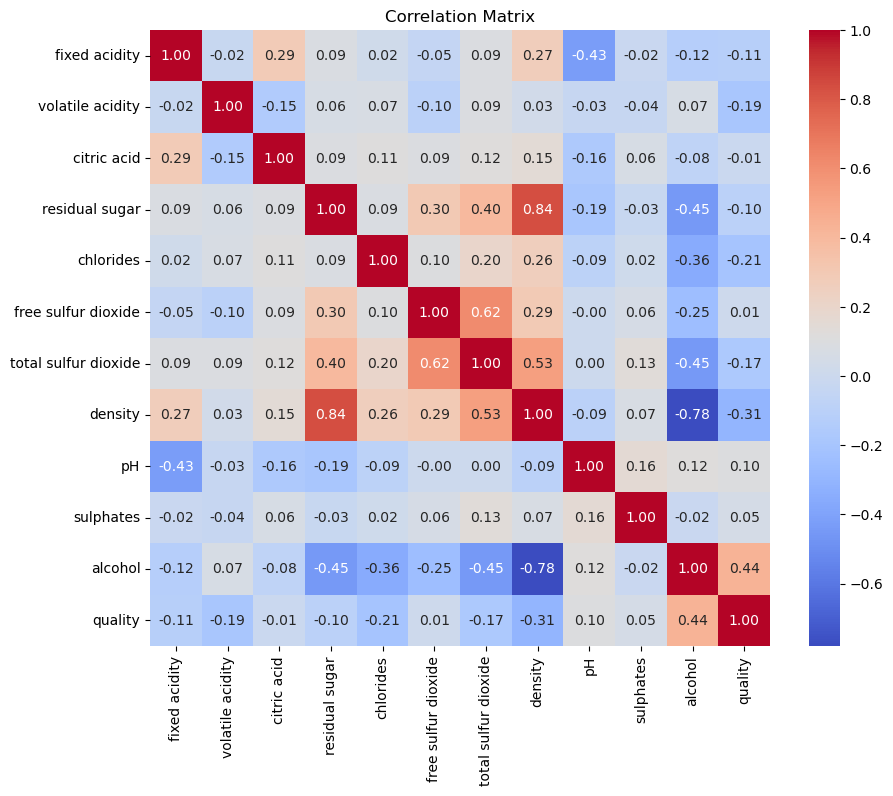

In [26]:
# Correlation Matrix
plt.figure(figsize=(10,8))
sns.heatmap(white_wine.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

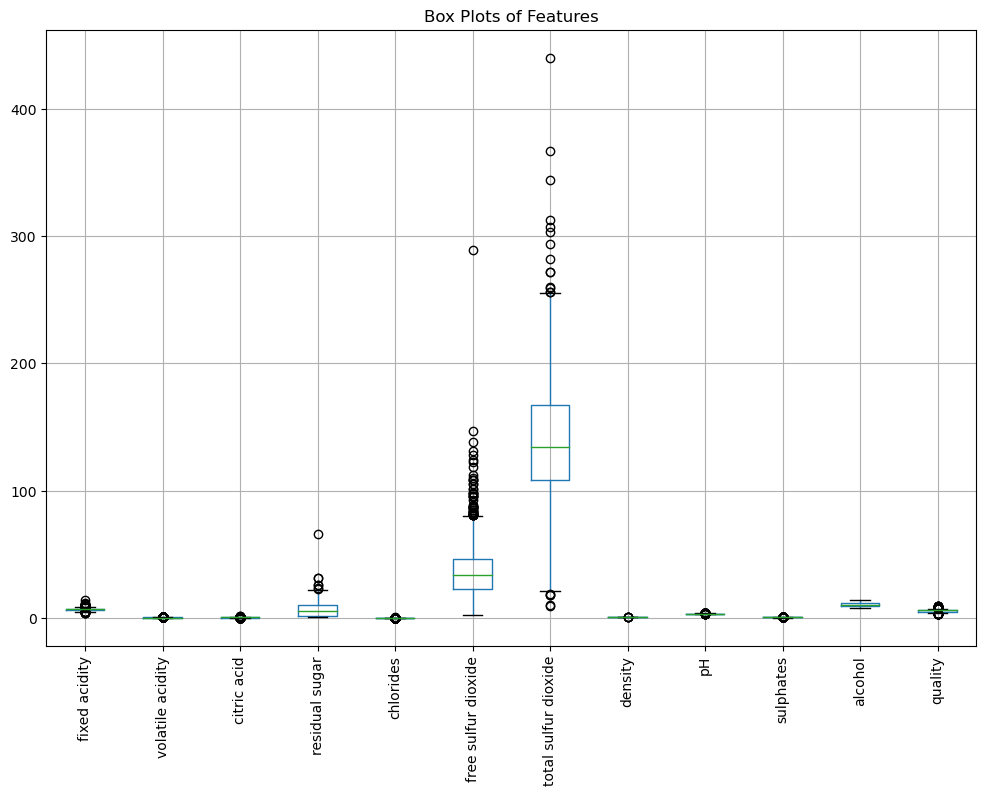

In [27]:
# Box Plots
plt.figure(figsize=(12,8))
white_wine.boxplot(rot=90)
plt.title("Box Plots of Features")
plt.show()

## Normalization

In [ ]:
X = white_wine.drop('quality', axis=1)

y = white_wine['quality']

In [48]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


In [49]:
y.head()

0    6
1    6
2    6
3    6
4    6
Name: quality, dtype: int64

## Range Scaling

In [ ]:
means = np.array(X.mean())
mins = np.array(X.min())
maxs = np.array(X.max())  

X_range =  X

for index, row in X_range.iterrows():
    X_range.loc[index] = (row - means) / (maxs - mins)


In [66]:
X_range.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.013963,-0.008080,0.015547,0.219457,-0.002292,0.033770,0.073409,0.134425,-0.171151,-0.046334,-0.276495
1,-0.053345,0.021332,0.003499,-0.073488,0.009578,-0.074244,-0.014758,-0.000528,0.101576,0.000178,-0.163591
2,0.119732,0.001724,0.039644,0.007800,0.012545,-0.018495,-0.095964,0.020679,0.065212,-0.057961,-0.066817
3,0.033193,-0.047295,-0.008549,0.032340,0.036284,0.040738,0.110532,0.030319,0.001576,-0.104473,-0.099075
4,0.033193,-0.047295,-0.008549,0.032340,0.036284,0.040738,0.110532,0.030319,0.001576,-0.104473,-0.099075


## Standardization

In [68]:
zscore_scaler = StandardScaler()
zscore_array = zscore_scaler.fit_transform(X)
X_zscore = pd.DataFrame(zscore_array, columns=X.columns)

In [69]:
X_zscore.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.172097,-0.081770,0.213280,2.821349,-0.035355,0.569932,0.744565,2.331512,-1.246921,-0.349184,-1.393152
1,-0.657501,0.215896,0.048001,-0.944765,0.147747,-1.253019,-0.149685,-0.009154,0.740029,0.001342,-0.824276
2,1.475751,0.017452,0.543838,0.100282,0.193523,-0.312141,-0.973336,0.358665,0.475102,-0.436816,-0.336667
3,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203
4,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203


# Fuzzy c-Means (FCM)

aplicar a varias seeds e contar o numero de vezes em que cada c é o minimo de cada seed e escolher o c que foi o minimo mais vezes

In [72]:
c_min, c_max = 3, 8
cost_values = []

# Iterate over different cluster numbers
for c in range(c_min, c_max):
    # Apply Fuzzy C-Means
    cntr, u, cost, _, _, _, _ = fuzz.cluster.cmeans(
        X_range, c, m=2, error=0.005, maxiter=1000, init=None
    )
    
    cost_values.append(cost[-1])  # Store the final cost

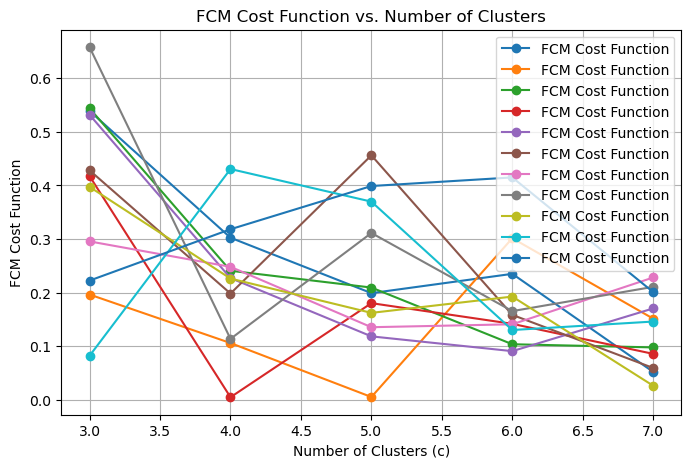

In [ ]:
# Plot cost function vs. number of clusters
plt.figure(figsize=(8,5))
plt.plot(range(c_min, c_max), cost_values, marker='o', linestyle='-', label="FCM Cost Function")  # Adiciona label
plt.xlabel("Number of Clusters (c)")
plt.ylabel("FCM Cost Function")
plt.title("FCM Cost Function vs. Number of Clusters")
plt.grid()
plt.legend()
plt.show()


#fazer varias iteraçoes e ver qual o numero mais comum de clusters.

In [ ]:
# ...

# All data - white + red wine

In [ ]:
# ...